# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [2]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
--2020-12-09 18:08:12--  https://docs.google.com/uc?export=download&confirm=ghZC&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 172.217.7.238, 2607:f8b0:4004:802::200e
Connecting to docs.google.com (docs.google.com)|172.217.7.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-48-docs.googleusercontent.com/docs/securesc/i02mqdhd8s5dvm4oiep15opdmqbdnmn3/it4iaambjdnm95krb1s74e0rjs6p4uvb/1607537250000/06419056966375271799/14987186607940019863Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-12-09 18:08:12--  https://do

In [3]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


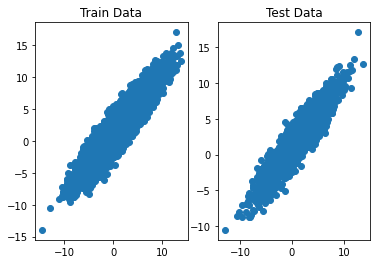

Dataset 2


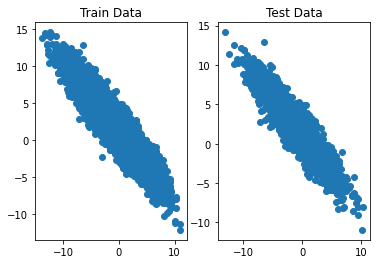

In [3]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [40]:
from tqdm import trange, tqdm_notebook

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.nn.utils import weight_norm

from collections import namedtuple
from copy import deepcopy
# import deepul.pytorch_util as ptu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
VaeOutput = namedtuple('VaeOutput', (
      'encoded_sample', 
      'mu_z', 
      'log_sigma_z', 
      'decoded_sample', 
      'mu_x', 
      'log_sigma_x'
    )
)


class Network(nn.Module):
  def __init__(self, input_size, hidden_sizes):
    super().__init__()

    layer_list = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
    size_pairs = list(zip(hidden_sizes[:-1], hidden_sizes[1:]))
    for h1, h2 in size_pairs:
      layer_list.append(nn.Linear(h1, h2))
      layer_list.append(nn.ReLU())

    self.layers = nn.Sequential(*layer_list)
  
  def forward(self, x):
    return self.layers(x)


class VaeBlock(nn.Module):
  def __init__(self, input_size, output_size, hidden_sizes):
    super().__init__()
    self.layers = Network(input_size, hidden_sizes)
    self.mu = nn.Linear(hidden_sizes[-1], output_size)
    self.log_sigma = nn.Linear(hidden_sizes[-1], output_size)
  
  def forward(self, x, use_noise=True):
    x = self.layers(x)
    mu = self.mu(x)
    log_sigma = self.log_sigma(x)
    if use_noise:
      sample = mu + log_sigma.exp() * torch.randn_like(mu).to(device)
    else:
      sample = mu[:]
    return sample, mu, log_sigma
  

class VAE(nn.Module):
  def __init__(self, input_size, latent_size, output_size, encoder_sizes, decoder_sizes):
    super().__init__()

    self.encoder = VaeBlock(input_size, latent_size, encoder_sizes)
    self.decoder = VaeBlock(latent_size, output_size, decoder_sizes)
    self.latent_size = latent_size

  def forward(self, x):
    z_encoded, mu_z, log_sigma_z = self.encoder(x)
    x_decoded, mu_x, log_sigma_x = self.decoder(z_encoded)
    return VaeOutput(
        z_encoded,
        mu_z,
        log_sigma_z,
        x_decoded,
        mu_x,
        log_sigma_x
    )
  
  def sample(self, num_samples, use_noise):
    with torch.no_grad():
      z = torch.randn(num_samples, self.latent_size).to(device)
      x_decoded, _, _ = self.decoder(z, use_noise)
    return x_decoded.cpu().numpy()


class VaeLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x, vae_output: VaeOutput):
    mu_x = vae_output.mu_x
    log_sigma_x = vae_output.log_sigma_x
    rec_loss = self._reconstruction_loss(x, mu_x, log_sigma_x)

    mu_z = vae_output.mu_z
    log_sigma_z = vae_output.log_sigma_z
    kl_loss = self._kl_divergence_loss(mu_z, log_sigma_z)

    return rec_loss + kl_loss, rec_loss, kl_loss
  
  def _reconstruction_loss(self, x, mu, log_sigma):
    dist = Normal(mu, log_sigma.exp())
    log_prob = dist.log_prob(x).sum(dim=1)
    return -log_prob.mean()
  
  def _kl_divergence_loss(self, mu, log_sigma):
    sigma = log_sigma.exp()
    kl_term = mu.pow(2) + sigma.pow(2) - 2 * log_sigma - 1
    kl = 0.5 * kl_term.sum(dim=1)
    return kl.mean()

In [60]:
def save_states(model, optimizer, epoch_num):
  model_name = f'{model.__class__.__name__}_State_Dict_at_epoch_{epoch_num}.pkl'
  optimizer_name = f'Opt_State_Dict_at_epoch_{epoch_num}.pkl'
  torch.save(model.state_dict(), model_name)
  torch.save(optimizer.state_dict(), optimizer_name)
  print('------- MODEL SAVED -------')
  print()

In [7]:
def train_single_epoch(model, data, optimizer, loss_type=VaeLoss):
    model.train()

    total_losses = []
    rec_losses = []
    kl_losses = []
    vae_loss = loss_type()
    for x in data:
      x = x.to(device)
      vae_output = model(x)
      total_loss, rec_loss, kl_loss = vae_loss(x, vae_output)
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      total_losses.append(total_loss.item())
      rec_losses.append(rec_loss.item())
      kl_losses.append(kl_loss.item())
    return total_losses, rec_losses, kl_losses


def eval_model(model, data, loss_type=VaeLoss):
    model.eval()
    total_loss_sum = 0
    rec_loss_sum = 0
    kl_loss_sum = 0
    vae_loss = loss_type()
    with torch.no_grad():
      for x in data:
        x = x.to(device)
        vae_output = model(x)
        total_loss, rec_loss, kl_loss = vae_loss(x, vae_output)

        total_loss_sum += total_loss.item() * x.shape[0]
        rec_loss_sum += rec_loss.item() * x.shape[0]
        kl_loss_sum += kl_loss.item() * x.shape[0]

    return total_loss_sum / len(data.dataset), rec_loss_sum / len(data.dataset), kl_loss_sum / len(data.dataset)


def train_model(model, train_data, test_data, epochs, lr, batch_size, loss_type=VaeLoss):
  model.train()
  dataloader_train = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dataloader_test = data.DataLoader(test_data, batch_size=batch_size)

  train_total = []
  train_rec = []
  train_kl = []

  test_total = []
  test_rec = []
  test_kl = []

  optimizer = optim.Adam(model.parameters(), lr=lr)
  for ep in tqdm_notebook(range(epochs)):
    total, rec, kl = train_single_epoch(model, dataloader_train, optimizer, loss_type)
    train_total = train_total + total
    train_rec = train_rec + rec
    train_kl = train_kl + kl

    total, rec, kl = eval_model(model, dataloader_test, loss_type)
    test_total.append(total)
    test_rec.append(rec)
    test_kl.append(kl)
    print('loss:', total, 'at epoch', ep)
    save_states(model, optimizer, ep)
  print('final loss:', test_total[-1], 'at epoch', epochs)
  train_losses = (
      train_total,
      train_rec,
      train_kl
  )
  test_losses = (
      test_total,
      test_rec,
      test_kl
  )
  return train_losses, test_losses

In [8]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 
    input_size = 2
    output_size = 2
    latent_size = 2
    encoder_sizes = [64, 128, 256]
    decoder_sizes = [256, 128, 64]
    model = VAE(input_size, latent_size, output_size, encoder_sizes, decoder_sizes)
    model = model.to(device)
    train_losses, test_losses = train_model(model, train_data, test_data, epochs=15, lr=1e-3, batch_size=64)

    train_losses = np.array(train_losses).T
    test_losses = np.array(test_losses).T
      
    noisy_samples = model.sample(num_samples=1000, use_noise=True)
    mean_samples = model.sample(num_samples=1000, use_noise=False)
    return train_losses, test_losses, noisy_samples, mean_samples

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 5.391212351989746 at epoch 0
loss: 5.3655834815979 at epoch 1
loss: 5.382067860412597 at epoch 2
loss: 5.338372781372071 at epoch 3
loss: 5.3178196716308594 at epoch 4
loss: 5.308361037445068 at epoch 5
loss: 4.654498786926269 at epoch 6
loss: 4.451276332855224 at epoch 7
loss: 4.47638201713562 at epoch 8
loss: 4.4911974369049075 at epoch 9
loss: 4.473187986755371 at epoch 10
loss: 4.433374577331543 at epoch 11
loss: 4.430555172729492 at epoch 12
loss: 4.4656508255004885 at epoch 13
loss: 4.426962254333496 at epoch 14

final loss: 4.426962254333496 at epoch 15
Final -ELBO: 4.4270, Recon Loss: 2.7978, KL Loss: 1.6292


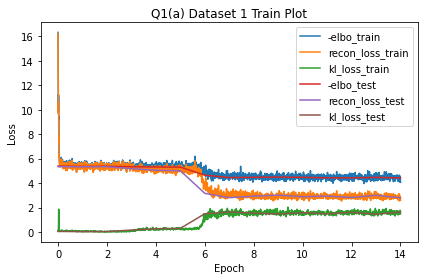

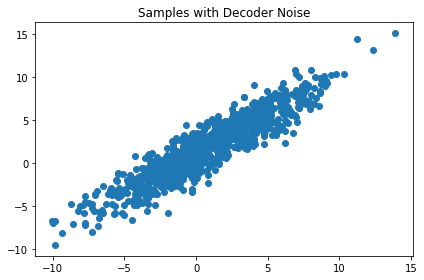

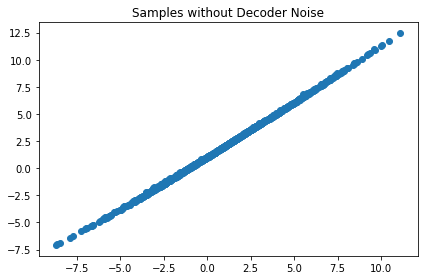

In [ ]:
q1_save_results('a', 1, q1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 5.36355679397583 at epoch 0
loss: 5.316666304016113 at epoch 1
loss: 5.305258327484131 at epoch 2
loss: 5.301833358001709 at epoch 3
loss: 5.277770782470703 at epoch 4
loss: 4.770397862625122 at epoch 5
loss: 4.518935641479493 at epoch 6
loss: 4.471045491790772 at epoch 7
loss: 4.459211573028565 at epoch 8
loss: 4.502290476989746 at epoch 9
loss: 4.487348907470703 at epoch 10
loss: 4.469874467086792 at epoch 11
loss: 4.470952033233643 at epoch 12
loss: 4.476588594818115 at epoch 13
loss: 4.472381973266602 at epoch 14

final loss: 4.472381973266602 at epoch 15
Final -ELBO: 4.4724, Recon Loss: 2.8411, KL Loss: 1.6313


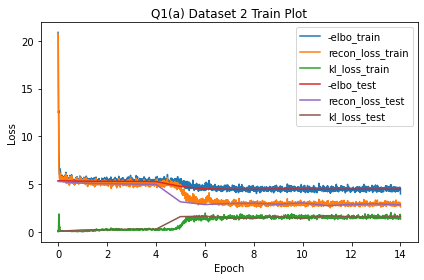

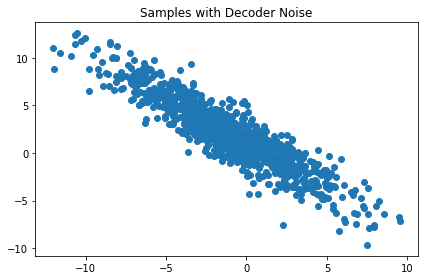

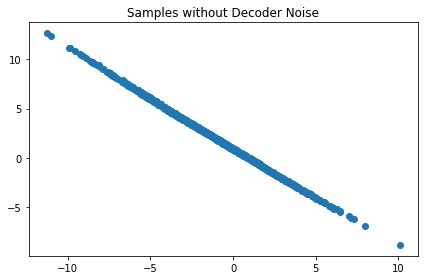

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


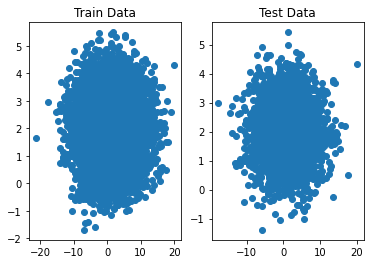

Dataset 2


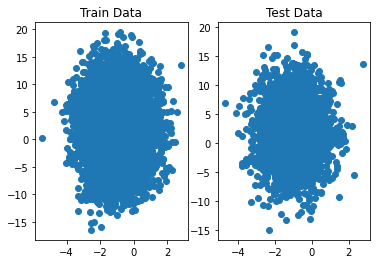

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 4.437207614898681 at epoch 0
loss: 4.436777067565918 at epoch 1
loss: 4.4335742126464845 at epoch 2
loss: 4.42460378112793 at epoch 3
loss: 4.4322551902770995 at epoch 4
loss: 4.430917410278321 at epoch 5
loss: 4.42577257232666 at epoch 6
loss: 4.421743970489502 at epoch 7
loss: 4.44357590751648 at epoch 8
loss: 4.424234979248047 at epoch 9
loss: 4.421601839447021 at epoch 10
loss: 4.425278601074218 at epoch 11
loss: 4.430533374786377 at epoch 12
loss: 4.428350168609619 at epoch 13
loss: 4.4290716842651365 at epoch 14

final loss: 4.4290716842651365 at epoch 15
Final -ELBO: 4.4291, Recon Loss: 4.4223, KL Loss: 0.0067


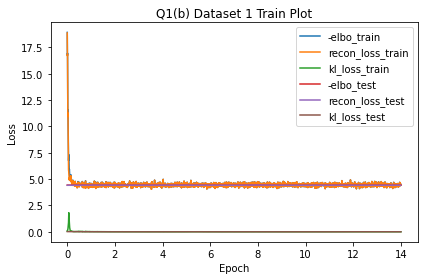

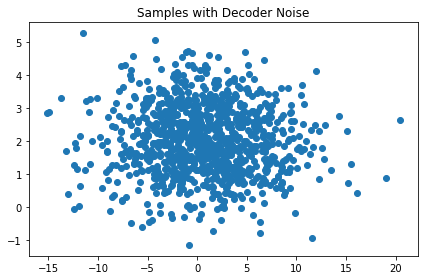

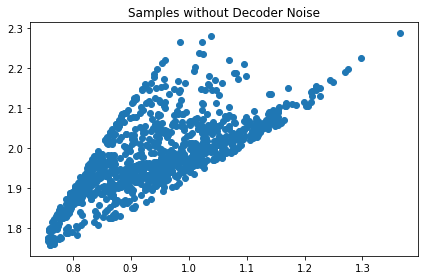

In [ ]:
q1_save_results('b', 1, q1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 4.434669832611084 at epoch 0
loss: 4.43221138381958 at epoch 1
loss: 4.4202459274292 at epoch 2
loss: 4.432133882904052 at epoch 3
loss: 4.434336871337891 at epoch 4
loss: 4.433464414215088 at epoch 5
loss: 4.441702883911133 at epoch 6
loss: 4.440692442321778 at epoch 7
loss: 4.436703038787842 at epoch 8
loss: 4.4263980751037595 at epoch 9
loss: 4.4526915367126465 at epoch 10
loss: 4.425738339614868 at epoch 11
loss: 4.4319395957946774 at epoch 12
loss: 4.4430795001983645 at epoch 13
loss: 4.425022541809082 at epoch 14

final loss: 4.425022541809082 at epoch 15
Final -ELBO: 4.4250, Recon Loss: 4.4230, KL Loss: 0.0020


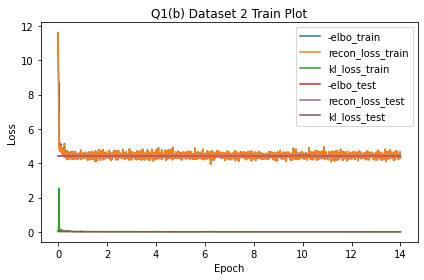

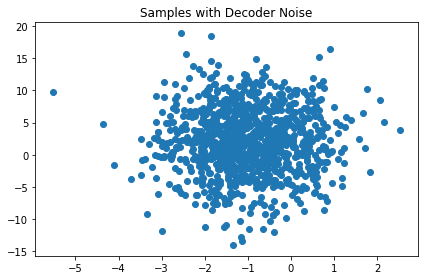

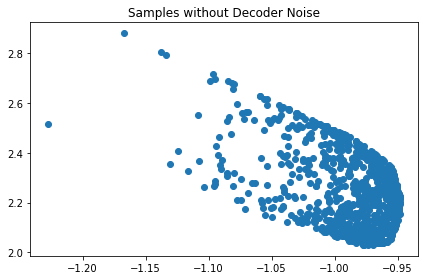

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without decoder noise in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

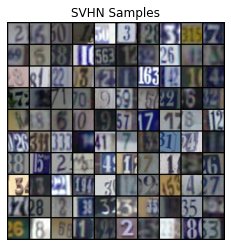

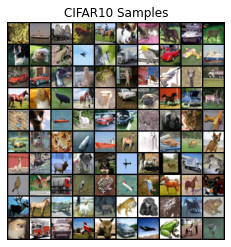

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [9]:
ConvVaeOutput = namedtuple('ConvVaeOutput', (
    'encoded_sample',
    'mu',
    'log_sigma',
    'decoded_sample'
  )
)


class ConvEncoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.mu = nn.Linear(4 * 4 * 256, latent_size)
    self.log_sigma = nn.Linear(4 * 4 * 256, latent_size)
    self.actv = nn.ReLU()
    self.latent_size = latent_size
  
  def forward(self, x, use_noise=True):
    x = 2 * x - 1
    batch_size = x.shape[0]
    x = self.actv(self.conv1(x))
    x = self.actv(self.conv2(x))
    x = self.actv(self.conv3(x))
    x = self.actv(self.conv4(x))
    x = x.view(batch_size, -1)

    mu = self.mu(x)
    log_sigma = self.log_sigma(x)
    if use_noise:
      sample = mu + log_sigma.exp() * torch.randn_like(mu).to(device)
    else:
      sample = mu[:]
    return sample, mu, log_sigma


class ConvDecoder(nn.Module):
  def __init__(self, latent_size, output_shape):
    super().__init__()

    self.shape = (128, output_shape[1] // 8, output_shape[2] // 8)
    self.output_shape = output_shape
    self.latent_size = latent_size
    self.linear = nn.Linear(latent_size, np.prod(self.shape))
    self.conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=output_shape[0], kernel_size=3, stride=1, padding=1)
    self.actv = nn.ReLU()
  
  def forward(self, x):
    batch_size = x.shape[0]
    x = self.linear(x)
    x = x.view(batch_size, *self.shape)
    x = self.actv(self.conv1(x))
    x = self.actv(self.conv2(x))
    x = self.actv(self.conv3(x))
    x = self.conv4(x)
    return x

class ConvVAE(nn.Module):
  def __init__(self, latent_size, img_shape):
    super().__init__()
    
    self.latent_size = latent_size
    self.encoder = ConvEncoder(latent_size)
    self.decoder = ConvDecoder(latent_size, img_shape)

  def forward(self, x):
    z, mu, log_sigma = self.encoder(x)
    x_rec = self.decoder(z)
    return ConvVaeOutput(z, mu, log_sigma, x_rec)
  
  def sample(self, num_samples):
    with torch.no_grad():
      z = torch.randn(num_samples, self.latent_size).to(device)
      result = self.decoder(z)
      result = torch.clamp(result, -1, 1) * 0.5 + 0.5
      result = result.cpu().numpy() * 255.0
    return np.transpose(result, (0, 2, 3, 1))

class ConvVaeLoss(nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self, x, vae_output):
    x = 2 * x - 1
    mu = vae_output.mu
    log_sigma = vae_output.log_sigma
    x_rec = vae_output.decoded_sample
    rec_loss = self._reconstruction_loss(x, x_rec)
    kl_loss = self._kl_divergence_loss(mu, log_sigma)
    return rec_loss + kl_loss, rec_loss, kl_loss
  
  def _reconstruction_loss(self, x, x_rec):
    mse = F.mse_loss(x, x_rec, reduction='none').view(x.shape[0], -1).sum(1)
    return mse.mean()
  
  def _kl_divergence_loss(self, mu, log_sigma):
    sigma = log_sigma.exp()
    kl_term = mu.pow(2) + sigma.pow(2) - 2 * log_sigma - 1
    kl = 0.5 * kl_term.sum(dim=1)
    return kl.mean()

In [10]:
def generate_from_data(model, data_samples, num_samples):
  dataloader = data.DataLoader(data_samples, batch_size=num_samples, shuffle=True)
  real_images = next(iter(dataloader)).to(device)
  with torch.no_grad():
    vae_output = model(real_images)
    rec_images = vae_output.decoded_sample
    rec_images = torch.clamp(rec_images, -1, 1)
  result = torch.stack([real_images, rec_images], dim=1)
  result = result * 0.5 + 0.5
  result = result.view(-1, 3, 32, 32)
  result = result.cpu().numpy()
  return np.transpose(result, (0, 2, 3, 1)) * 255


def generate_interpolations(model, data_samples, num_samples):
  dataloader = data.DataLoader(data_samples, batch_size=num_samples, shuffle=True)
  real_images = next(iter(dataloader)).to(device)
  start_images = real_images[:num_samples // 2]
  finish_images = real_images[num_samples // 2: ]
  with torch.no_grad():
    z1, _, _ = model.encoder(start_images)
    z2, _, _ = model.encoder(finish_images)
    interp_coeffs = np.linspace(0, 1, 10)
    result = []
    for w in interp_coeffs:
      z_mixed = z1 * (1 - w) + z2 * w
      rec_images = model.decoder(z_mixed)
      result.append(rec_images)
  result = torch.stack(result, dim=1)
  result = torch.clamp(result, -1, 1) * 0.5 + 0.5
  result = result.view(-1, 3, 32, 32)
  result = result.cpu().numpy()
  return np.transpose(result, (0, 2, 3, 1)) * 255

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.0).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.0).astype('float32')

    model = ConvVAE(
        latent_size=16,
        img_shape=(3, 32, 32)
    ).to(device)

    train_losses, test_losses = train_model(model, train_data, test_data,\
                                            epochs=20, lr=1e-3, batch_size=128, loss_type=ConvVaeLoss)
    train_losses = np.array(train_losses).T
    test_losses = np.array(test_losses).T

    samples = model.sample(num_samples=100)
    rec_images = generate_from_data(model, test_data, 50)
    interpolations = generate_interpolations(model, test_data, 20)
    return train_losses, test_losses, samples, rec_images, interpolations

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 219.9514503173828 at epoch 0
------- MODEL SAVED -------

loss: 161.1473485595703 at epoch 1
------- MODEL SAVED -------

loss: 144.63838100585937 at epoch 2
------- MODEL SAVED -------

loss: 134.53704934082032 at epoch 3
------- MODEL SAVED -------

loss: 116.2900982421875 at epoch 4
------- MODEL SAVED -------

loss: 109.08675141601563 at epoch 5
------- MODEL SAVED -------

loss: 107.15105819091796 at epoch 6
------- MODEL SAVED -------

loss: 106.92054086914062 at epoch 7
------- MODEL SAVED -------

loss: 109.54197075195313 at epoch 8
------- MODEL SAVED -------

loss: 122.68367377929688 at epoch 9
------- MODEL SAVED -------

loss: 104.44375716552734 at epoch 10
------- MODEL SAVED -------

loss: 104.03489708251954 at epoch 11
------- MODEL SAVED -------

loss: 104.52084729003906 at epoch 12
------- MODEL SAVED -------

loss: 110.84682161865234 at epoch 13
------- MODEL SAVED -------

loss: 104.22998454589843 at epoch 14
------- MODEL SAVED -------

loss: 104.6482375366211

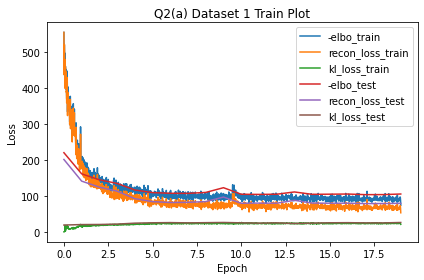

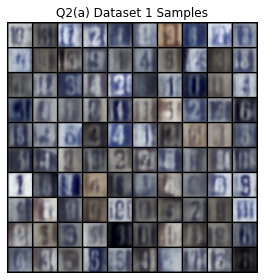

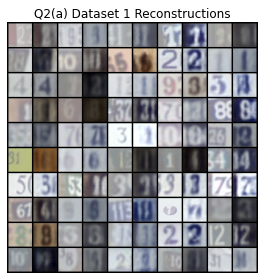

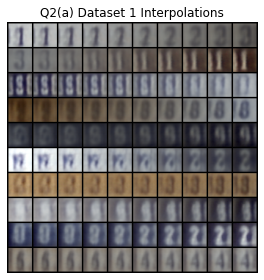

In [ ]:
q2_save_results('a', 1, q2_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 264.5875405761719 at epoch 0
------- MODEL SAVED -------

loss: 247.81600307617188 at epoch 1
------- MODEL SAVED -------

loss: 246.44076918945314 at epoch 2
------- MODEL SAVED -------

loss: 243.34538852539063 at epoch 3
------- MODEL SAVED -------

loss: 244.11020205078125 at epoch 4
------- MODEL SAVED -------

loss: 242.05628100585938 at epoch 5
------- MODEL SAVED -------

loss: 241.20712670898436 at epoch 6
------- MODEL SAVED -------

loss: 240.5560628417969 at epoch 7
------- MODEL SAVED -------

loss: 239.97689443359374 at epoch 8
------- MODEL SAVED -------

loss: 239.81978530273437 at epoch 9
------- MODEL SAVED -------

loss: 239.12037529296876 at epoch 10
------- MODEL SAVED -------

loss: 239.20354145507812 at epoch 11
------- MODEL SAVED -------

loss: 239.50964516601562 at epoch 12
------- MODEL SAVED -------

loss: 238.5838662597656 at epoch 13
------- MODEL SAVED -------

loss: 239.4891964355469 at epoch 14
------- MODEL SAVED -------

loss: 238.31294584960938

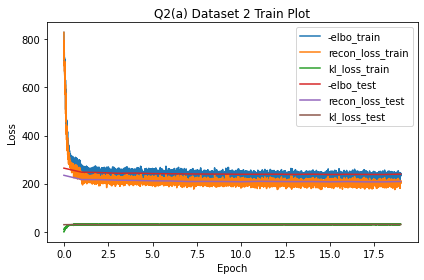

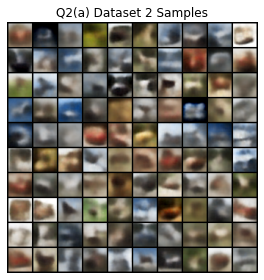

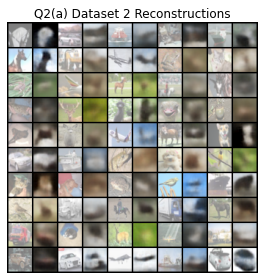

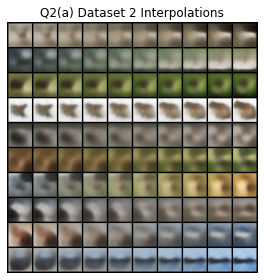

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 102.5659, Recon Loss: 80.2548, KL Loss: 22.3111


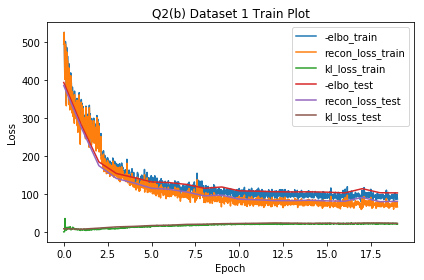

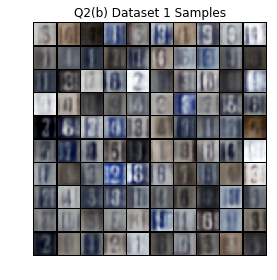

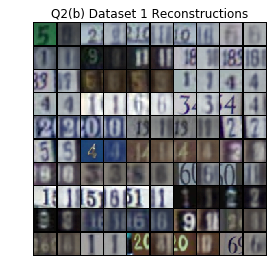

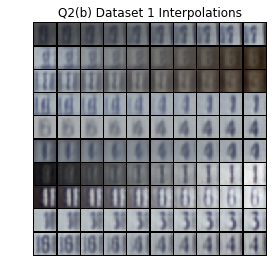

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

## PixelCNN

In [307]:
PixelCnnOutput = namedtuple('PixelCnnOutput', ('logits'))


class MaskConv(nn.Conv2d):
  def __init__(self, mask_type, condition_size, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.init_mask(mask_type)
    if condition_size is not None:
      self.condition_layer = nn.Linear(condition_size, self.out_channels)
  
  def init_mask(self, mask_type):
    mid = self.kernel_size[0] // 2

    self.mask[:, :, :mid] = 1
    self.mask[:, :, mid, :mid] = 1
    if mask_type == 'B':
      self.mask[:, :, mid, mid] = 1
  
  def forward(self, x, condition=None):
    x = F.conv2d(x, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
    if condition is not None:
      condition = self.condition_layer(condition)
      x = x + condition.reshape(condition.shape[0], self.out_channels, 1, 1)
    return x


class PixelCnnBlock(nn.Module):
  def __init__(self, mask_type, condition_size, channels_list, kernel_sizes, padding_sizes):
    super().__init__()

    assert len(channels_list) - len(kernel_sizes) == 1
    assert len(channels_list) - len(padding_sizes) == 1
    self.layer_list = nn.ModuleList([])
    channel_size_pairs = list(zip(channels_list[:-1], channels_list[1:]))
    for i, size_pair in enumerate(channel_size_pairs):
      ch1, ch2 = size_pair
      kernel_size = kernel_sizes[i]
      padding = padding_sizes[i]

      mask_conv = MaskConv(mask_type, condition_size, ch1, ch2, kernel_size, padding=padding)
      actv = nn.ReLU()

      self.layer_list.append(mask_conv)
      self.layer_list.append(actv)
  
  def forward(self, x, condition):
    residual = x
    for layer in self.layer_list:
      if isinstance(layer, MaskConv):
        x = layer(x, condition)
      else:
        x = layer(x)
    return x + residual


class PixelCnn(nn.Module):
  def __init__(self, in_shape, num_embeddings, d, condition_size=None):
    super().__init__()
    
    self.code_size = num_embeddings
    self.d = d
    self.in_shape = in_shape

    self.embedding = nn.Embedding(num_embeddings, d)
    blocks = []

    self.mask_conv1 = MaskConv('A', condition_size, d, d, 7, padding=3)
    blocks.append(
        PixelCnnBlock(
            mask_type='A',
            condition_size=condition_size,
            channels_list=[d, d // 2, d // 2, d],
            kernel_sizes=[1, 3, 1],
            padding_sizes=[0, 1, 0]
        )
    )

    blocks.append(
        PixelCnnBlock(
            mask_type='B',
            condition_size=condition_size,
            channels_list=[d, d // 2, d // 2, d],
            kernel_sizes=[1, 3, 1],
            padding_sizes=[0, 1, 0]
        )
    )

    blocks.append(
        PixelCnnBlock(
            mask_type='A',
            condition_size=condition_size,
            channels_list=[d, d // 2, d // 2, d],
            kernel_sizes=[1, 3, 1],
            padding_sizes=[0, 1, 0]
        )
    )

    self.blocks = nn.ModuleList(blocks)
    self.mask_conv2 = MaskConv('B', condition_size, d, 512, 1)
    self.mask_conv3 = MaskConv('B', condition_size, 512, self.code_size, 1)

  def forward(self, x, condition=None):
    x = self.embedding(x).permute(0, 3, 1, 2).contiguous()
    t = 0
    x = self.mask_conv1(x, condition)
    x = torch.relu(x)
    for block in self.blocks:
      x = block(x, condition)
    x = self.mask_conv2(x, condition)
    x = torch.relu(x)
    x = self.mask_conv3(x, condition)
    return PixelCnnOutput(x)

  def sample(self, num_samples, condition=None):
    samples = torch.zeros(num_samples, *self.in_shape).long().to(device)
    with torch.no_grad():
      for n in range(self.in_shape[0]):
        for c in range(self.in_shape[1]):
          logits = self.forward(samples, condition=condition).logits[:, :, n, c]
          probs = F.softmax(logits, dim=1)
          samples[:, n, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples


class PixelCnnLoss(nn.Module):
  num_losses_types = 1
  def __init__(self):
    super().__init__()

  def forward(self, x, pixel_cnn_output):
    loss = F.cross_entropy(pixel_cnn_output.logits, x)
    return [loss]

## VQ-VAE

In [300]:
VqVaeOutput = namedtuple('VqVaeOutput', ('x_rec', 'diff'))


class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
      
    def forward(self, x):
        return x + self.network(x)


class EmbeddingLayer(nn.Module):
    def __init__(self, size, d):
        super().__init__()
        self.embedding = nn.Embedding(size, d)

        self.d = d
        self.size = size

    def forward(self, z):
        b, c, h, w = z.shape
        inp = z.permute(0, 2, 3, 1).contiguous().view(-1, self.d)

        inp_square = inp.pow(2).sum(dim=1, keepdim=True)
        weight_square = self.embedding.weight.T.pow(2).sum(dim=0, keepdim=True)
        prod = torch.mm(inp, self.embedding.weight.T)

        distances = inp_square - 2 * prod + weight_square
        indices = torch.max(-distances, dim=1)[1].view(b, h, w)
        embedding = self.embedding(indices).permute(0, 3, 1, 2).contiguous()

        return embedding, (embedding - z).detach() + z, indices


class VQVAE(nn.Module):
    def __init__(self, d, size):
        super().__init__()
        self.size = size
        self.d = d
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResBlock(256),
            ResBlock(256),
        )

        self.embedding_layer = EmbeddingLayer(size, d)

        self.decoder = nn.Sequential(
            ResBlock(256),
            ResBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            _, _, indices = self.embedding_layer(z)
            return indices

    def decode(self, z):
        with torch.no_grad():
            z = self.embedding_layer.embedding(z)
            z = z.permute(0, 3, 1, 2).contiguous()
            return self.decoder(z).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        x = 2 * x - 1
        z = self.encoder(x)
        embedding, embedding_st, indices = self.embedding_layer(z)
        x_rec = self.decoder(embedding_st)

        diff1 = torch.mean((z - embedding.detach()) ** 2)
        diff2 = torch.mean((embedding - z.detach()) ** 2)
        return VqVaeOutput(x_rec, diff1 + diff2)


class VqVaeLoss(nn.Module):
  num_losses_types = 3

  def __init__(self):
    super().__init__()
  
  def forward(self, x, vqvae_output):
    x = 2 * x - 1
    x_rec, diff = vqvae_output.x_rec, vqvae_output.diff
    mse = F.mse_loss(x_rec, x)
    total_loss = mse + diff
    return total_loss, mse, diff

## Training

In [301]:
def save_states(model, optimizer, epoch_num):
  model_name = f'{model.__class__.__name__}_State_Dict_at_epoch_{epoch_num}.pkl'
  optimizer_name = f'{model.__class__.__name__}_Opt_State_Dict_at_epoch_{epoch_num}.pkl'
  torch.save(model.state_dict(), model_name)
  torch.save(optimizer.state_dict(), optimizer_name)
  print('------- MODEL SAVED -------')
  print()

In [302]:
def train_single_epoch(model, data, optimizer, loss_type):
    model.train()

    num_losses = loss_type.num_losses_types
    loss_lists = [[] for _ in range(num_losses)]
    model_loss = loss_type()
    for x in data:
      x = x.to(device)
      model_output = model(x)
      losses = model_loss(x, model_output)

      optimizer.zero_grad()
      losses[0].backward()
      optimizer.step()

      for i, loss in enumerate(losses):
        loss_lists[i].append(loss.item())

    return loss_lists


def eval_model(model, data, loss_type):
    model.eval()
    num_losses = loss_type.num_losses_types
    losses_sum = [0] * num_losses
    model_loss = loss_type()
    with torch.no_grad():
      for x in data:
        x = x.to(device)
        model_output = model(x)
        losses = model_loss(x, model_output)

      for i, loss in enumerate(losses):
        losses_sum[i] += loss.item() * x.shape[0]

    return [loss / len(data.dataset) for loss in losses_sum]


def train_model(model, train_data, test_data, epochs, lr, batch_size, loss_type):
  model.train()
  dataloader_train = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dataloader_test = data.DataLoader(test_data, batch_size=batch_size)

  num_losses = loss_type.num_losses_types
  train_losses = [[] for _ in range(num_losses)]

  test_losses = [[] for _ in range(num_losses)]

  optimizer = optim.Adam(model.parameters(), lr=lr)
  for ep in tqdm_notebook(range(epochs)):
    train_losses_after_epoch = train_single_epoch(model, dataloader_train, optimizer, loss_type)
    for i, loss in enumerate(train_losses_after_epoch):
      train_losses[i] = train_losses[i] + loss

    test_losses_after_eval = eval_model(model, dataloader_test, loss_type)
    for i, loss in enumerate(test_losses_after_eval):
      test_losses[i].append(loss)
    
    total = test_losses_after_eval[0]
    print('loss:', total, 'at epoch', ep)
    save_states(model, optimizer, ep)

  print('final loss:', test_losses[0][-1], 'at epoch', epochs)
  return train_losses, test_losses

In [303]:
def create_prior_dataset(model, dataset):
  dataloader = data.DataLoader(dataset, batch_size=128, shuffle=True)
  prior_dataset = []
  with torch.no_grad():
    for x in dataloader:
      x = x.to(device)
      z = model.encode(x)
      prior_dataset.append(z.long())
  return torch.cat(prior_dataset, dim=0)

def generate_reconstructions(model, dataset, num_samples=50):
    dataloader = data.DataLoader(dataset, batch_size=50, shuffle=True)
    x = next(iter(dataloader))
    with torch.no_grad():
        x = x.to(device)
        z = model.encode(x)
        x_recon = model.decode(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    result = np.stack((x, x_recon), axis=1)
    return result.reshape((-1, 32, 32, 3)) * 255

In [304]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.0).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.0).astype('float32')

    d = 256
    size = 128
    in_shape = (8, 8)
    vq_vae = VQVAE(d=d, size=size).to(device)
    train_losses, test_losses = train_model(vq_vae, train_data, test_data,\
                                            epochs=10, lr=1e-3, batch_size=128, loss_type=VqVaeLoss)

    pixel_cnn = PixelCnn(in_shape=in_shape, num_embeddings=size, d=128).to(device)
    prior_train = create_prior_dataset(vq_vae, train_data)
    prior_test = create_prior_dataset(vq_vae, test_data)

    prior_train_losses, prior_test_losses = train_model(pixel_cnn, prior_train, prior_test, \
                                                        epochs=10, lr=1e-3, batch_size=128, loss_type=PixelCnnLoss)

    train_losses = train_losses[0]
    test_losses = test_losses[0]
    prior_train_losses = prior_train_losses[0]
    prior_test_losses = prior_test_losses[0]

    samples = pixel_cnn.sample(100).long()
    samples = vq_vae.decode(samples) * 255.0

    reconstructions = generate_reconstructions(vq_vae, test_data, num_samples=50)
    return train_losses, test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 0.0022962120056152346 at epoch 0
------- MODEL SAVED -------

loss: 0.00291534538269043 at epoch 1
------- MODEL SAVED -------

loss: 0.0010511764526367187 at epoch 2
------- MODEL SAVED -------

loss: 0.0016430944442749023 at epoch 3
------- MODEL SAVED -------

loss: 0.0013598962783813477 at epoch 4
------- MODEL SAVED -------

loss: 0.0036328502655029295 at epoch 5
------- MODEL SAVED -------

loss: 0.0009358407020568848 at epoch 6
------- MODEL SAVED -------

loss: 0.0007711755752563477 at epoch 7
------- MODEL SAVED -------

loss: 0.0006065025329589844 at epoch 8
------- MODEL SAVED -------

loss: 0.00041954293251037595 at epoch 9
------- MODEL SAVED -------


final loss: 0.00041954293251037595 at epoch 10


loss: 0.0004432226181030273 at epoch 0
------- MODEL SAVED -------

loss: 0.000421527099609375 at epoch 1
------- MODEL SAVED -------

loss: 0.00041798014640808106 at epoch 2
------- MODEL SAVED -------

loss: 0.00041912927627563477 at epoch 3
------- MODEL SAVED -------

loss: 0.000404557466506958 at epoch 4
------- MODEL SAVED -------

loss: 0.000404247522354126 at epoch 5
------- MODEL SAVED -------

loss: 0.0004050267696380615 at epoch 6
------- MODEL SAVED -------

loss: 0.0003984198570251465 at epoch 7
------- MODEL SAVED -------

loss: 0.00043615012168884276 at epoch 8
------- MODEL SAVED -------

loss: 0.00040429725646972655 at epoch 9
------- MODEL SAVED -------


final loss: 0.00040429725646972655 at epoch 10
VQ-VAE Final Test Loss: 0.0004
PixelCNN Prior Final Test Loss: 0.0004


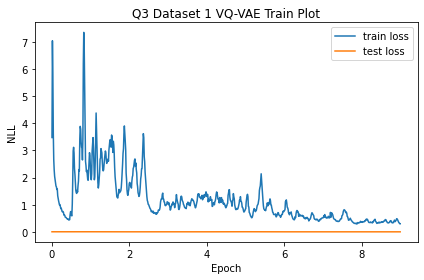

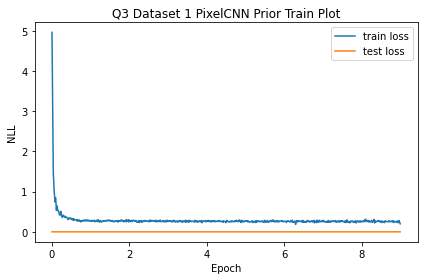

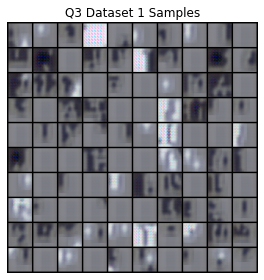

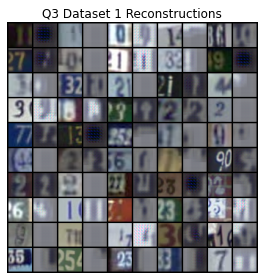

In [305]:
q3_save_results(1, q3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


loss: 0.0005726957321166992 at epoch 0
------- MODEL SAVED -------

loss: 0.0004051579475402832 at epoch 1
------- MODEL SAVED -------

loss: 0.0003105707883834839 at epoch 2
------- MODEL SAVED -------

loss: 0.000602393627166748 at epoch 3
------- MODEL SAVED -------

loss: 0.00043443164825439454 at epoch 4
------- MODEL SAVED -------

loss: 0.00042214064598083495 at epoch 5
------- MODEL SAVED -------

loss: 0.0004927379131317138 at epoch 6
------- MODEL SAVED -------

loss: 0.0004659897804260254 at epoch 7
------- MODEL SAVED -------

loss: 0.00040795249938964845 at epoch 8
------- MODEL SAVED -------

loss: 0.0003347009181976318 at epoch 9
------- MODEL SAVED -------


final loss: 0.0003347009181976318 at epoch 10


loss: 0.0010421908378601074 at epoch 0
------- MODEL SAVED -------

loss: 0.0010294179916381836 at epoch 1
------- MODEL SAVED -------

loss: 0.001027086353302002 at epoch 2
------- MODEL SAVED -------

loss: 0.0010273126602172852 at epoch 3
------- MODEL SAVED -------

loss: 0.001022496223449707 at epoch 4
------- MODEL SAVED -------

loss: 0.0010217723846435546 at epoch 5
------- MODEL SAVED -------

loss: 0.001017784595489502 at epoch 6
------- MODEL SAVED -------

loss: 0.001014993953704834 at epoch 7
------- MODEL SAVED -------

loss: 0.0010200422286987304 at epoch 8
------- MODEL SAVED -------

loss: 0.0010266658782958984 at epoch 9
------- MODEL SAVED -------


final loss: 0.0010266658782958984 at epoch 10
VQ-VAE Final Test Loss: 0.0003
PixelCNN Prior Final Test Loss: 0.0010


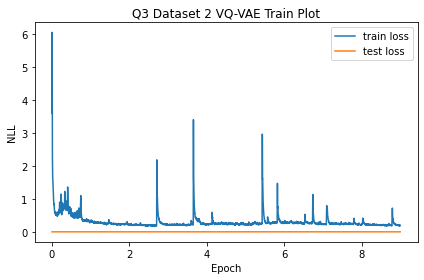

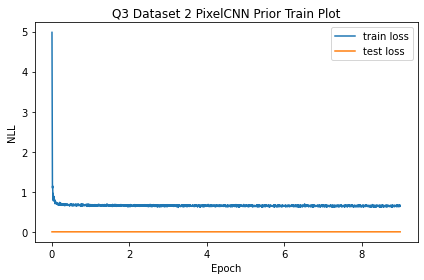

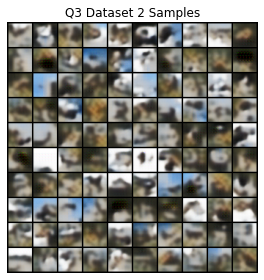

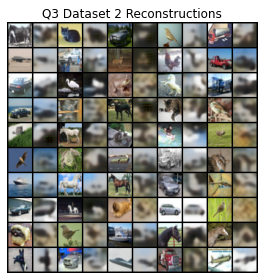

In [306]:
q3_save_results(2, q3)

# Question 4 Bonus [15pts]

## Part (a) Improving VQ-VAE Results [10pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

In [ ]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

In [ ]:
q4_b_save_results(q4_b)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)